# LangGraph Human In the Loop: 
## a. Streaming

### llm

In [1]:
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI
load_dotenv()

llm = ChatGoogleGenerativeAI(model='gemini-2.0-flash',temperature=0)


### State - Message from Langchain

In [2]:

from langchain_core.messages import AnyMessage, HumanMessage, AIMessage, trim_messages

from langgraph.graph.message import add_messages, RemoveMessage

messages = [AIMessage(f"Did you watch the game on 2024 IPL Final?", name="Gemini")]
messages.append(HumanMessage(f"Not ringing a bell. Can you tell me what happened?", name="Alice"))

for m in messages:
	m.pretty_print()

================================== Ai Message ==================================
Name: Gemini

Did you watch the game on 2024 IPL Final?
================================ Human Message =================================
Name: Alice

Not ringing a bell. Can you tell me what happened?


In [3]:
llm.invoke(messages)

AIMessage(content='The Kolkata Knight Riders (KKR) defeated the Sunrisers Hyderabad (SRH) in the 2024 IPL final. KKR dominated the match, winning by 8 wickets. It was a pretty one-sided affair.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--f787054f-44cf-40f7-996c-c289243f17f9-0', usage_metadata={'input_tokens': 26, 'output_tokens': 50, 'total_tokens': 76, 'input_token_details': {'cache_read': 0}})

### Memory management - Adding memory and managing context window - summarization

In [4]:
from typing import TypedDict
from langchain_core.messages import AnyMessage, HumanMessage, AIMessage, SystemMessage

from langgraph.graph import MessagesState
class State(MessagesState):
    summary: str

In [5]:
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage


def chat_node(state: State):
    summary = state.get("summary", "")

    if summary:
        system_message = f"Summary of our conversation earlier: {summary}"
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
    
    response = llm.invoke(messages)
    return {"messages": response}



In [6]:
def summarize_conversation(state: State):
    summary = state.get('summary', '')

    if summary:
        print("Updating summary")
        summary_msg = HumanMessage(
            content=f"This is the summary of our conversation: {summary}"
        )
    else:
        print("Creating summary")
        summary_msg = HumanMessage(
            content="Create a summary of the above conversation: "
        )
    all_msgs = state['messages']
    messages = all_msgs + [summary_msg]
    res = llm.invoke(messages)
    return {
        'summary': res.content,
        'messages': [RemoveMessage(id=m.id) for m in all_msgs[:-2]]
    }

In [7]:
from langgraph.graph import END
def should_continue(state: MessagesState):
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 4:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END

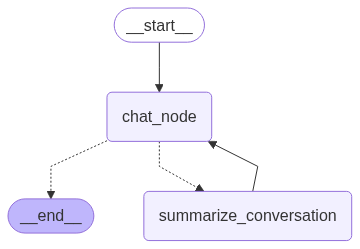

In [8]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("chat_node", chat_node)
workflow.add_node("summarize_conversation", summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "chat_node")
workflow.add_conditional_edges("chat_node", should_continue, {  # Use should_continue instead of summarize_conversation
    "summarize_conversation": "summarize_conversation",
    END: END
})
workflow.add_edge("summarize_conversation", "chat_node")  # Add edge back to chat_node after summarizing

# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

### Streaming full state

#### Streaming modes
1. values - a snapshot of state is streamed on every node
2. updates - a diff, just streams what was updated since the prev node

#### mode: values

In [9]:
config = {"configurable": {"thread_id": "1"}}

In [ ]:
async for chunk in graph.astream({"messages": [HumanMessage(content="hi! I'm Alice")]}, config=config, stream_mode='values'):
    print(chunk) # Notice that in the first print we see the human message, in the second we see human and AI message

{'messages': [HumanMessage(content="hi! I'm Alice", additional_kwargs={}, response_metadata={}, id='fcfab8fb-c09b-4921-993d-2b40d8f793f7')]}
{'messages': [HumanMessage(content="hi! I'm Alice", additional_kwargs={}, response_metadata={}, id='fcfab8fb-c09b-4921-993d-2b40d8f793f7'), AIMessage(content="Hi Alice! It's nice to meet you. How can I help you today?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--947e2bcf-5443-4633-b7f4-da631722070f-0', usage_metadata={'input_tokens': 6, 'output_tokens': 19, 'total_tokens': 25, 'input_token_details': {'cache_read': 0}})]}


#### mode: updates

In [ ]:
async for chunk in graph.astream({"messages": [HumanMessage(content="hi! I'm Alice")]}, config=config, stream_mode='updates'):
    print(chunk) # here we will see the update since last state

{'chat_node': {'messages': AIMessage(content='You already said that! 😉 Hi Alice, it\'s nice to "see" you again. What can I do for you this time?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--3a14ef45-2e9e-4865-a11c-0f3daae8a7be-0', usage_metadata={'input_tokens': 30, 'output_tokens': 30, 'total_tokens': 60, 'input_token_details': {'cache_read': 0}})}}


### Streaming Tokens

In [15]:
config = {"configurable": {"thread_id": "2"}}
async for event in graph.astream_events({"messages": [HumanMessage(content="hi! I'm Alice")]}, config=config, version='v2'):
  print(f"{event['event'] = }")
  print(f"""
    Node: {event['metadata'].get('langgraph_node', '')}
    Name: {event['name']}
""")

event['event'] = 'on_chain_start'

    Node: 
    Name: LangGraph

event['event'] = 'on_chain_start'

    Node: chat_node
    Name: chat_node

event['event'] = 'on_chat_model_start'

    Node: chat_node
    Name: ChatGoogleGenerativeAI

event['event'] = 'on_chat_model_stream'

    Node: chat_node
    Name: ChatGoogleGenerativeAI

event['event'] = 'on_chat_model_stream'

    Node: chat_node
    Name: ChatGoogleGenerativeAI

event['event'] = 'on_chat_model_stream'

    Node: chat_node
    Name: ChatGoogleGenerativeAI

event['event'] = 'on_chat_model_end'

    Node: chat_node
    Name: ChatGoogleGenerativeAI

event['event'] = 'on_chain_start'

    Node: chat_node
    Name: should_continue

event['event'] = 'on_chain_end'

    Node: chat_node
    Name: should_continue

event['event'] = 'on_chain_stream'

    Node: chat_node
    Name: chat_node

event['event'] = 'on_chain_end'

    Node: chat_node
    Name: chat_node

event['event'] = 'on_chain_stream'

    Node: 
    Name: LangGraph

event

### playing with data

In [ ]:
node_to_stream = 'chat_node'
config = {"configurable": {"thread_id": "3"}}
input_message = HumanMessage(content="Hans Zimmer recent works")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        print(event["data"])


{'chunk': AIMessageChunk(content='Hans', additional_kwargs={}, response_metadata={'safety_ratings': []}, id='run--347f8e15-ac17-4aea-a2bf-01139f1ccdbb', usage_metadata={'input_tokens': 5, 'output_tokens': 0, 'total_tokens': 5, 'input_token_details': {'cache_read': 0}})}
{'chunk': AIMessageChunk(content=' Zimmer has been', additional_kwargs={}, response_metadata={'safety_ratings': []}, id='run--347f8e15-ac17-4aea-a2bf-01139f1ccdbb', usage_metadata={'output_tokens': 0, 'total_tokens': 0, 'input_tokens': 0, 'input_token_details': {'cache_read': 0}})}
{'chunk': AIMessageChunk(content=" incredibly busy in recent years! Here's a rundown of some of his most notable", additional_kwargs={}, response_metadata={'safety_ratings': []}, id='run--347f8e15-ac17-4aea-a2bf-01139f1ccdbb', usage_metadata={'output_tokens': 0, 'total_tokens': 0, 'input_tokens': 0, 'input_token_details': {'cache_read': 0}})}
{'chunk': AIMessageChunk(content=' works from the past few years:\n\n**Film Scores:**\n\n*   **', add

### stream only contents

In [17]:
node_to_stream = 'chat_node'
config = {"configurable": {"thread_id": "4"}}
input_message = HumanMessage(content="Hans Zimmer recent works")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        print(event["data"]['chunk'].content)

Hans
 Zimmer has been
 incredibly busy in recent years! Here's a rundown of some of his most notable
 works from the past few years:

**Film Scores:**

*   **
Dune: Part Two (2024):** Continuing his Oscar-winning work from the first film, Zimmer delivers another epic and immersive score, expanding
 on the themes and introducing new motifs.
*   **The Creator (2023):** A sci-fi score that blends orchestral elements with electronic textures
, creating a unique and thought-provoking soundscape.
*   **Dune (2021):** This score won Zimmer his second Academy Award. It's a groundbreaking work, using unconventional instruments and vocal techniques to create a
 truly alien and awe-inspiring sound.
*   **No Time to Die (2021):** Zimmer took over scoring duties for the latest James Bond film, delivering a powerful and emotional score that honors the franchise's legacy while adding
 his own distinctive touch.
*   **Top Gun: Maverick (2022):** Collaborating with Harold Faltermeyer and Lorne Balfe, Z